# Imports

In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio.PDB import *
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import esm

torch.set_grad_enabled(False)

# Define Functions

## Parsing alignments

In [2]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

## Converting structures to contacts

In [3]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

## Subsampling MSA

In [4]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

## Compute contact precisions

In [5]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

## Drop missing residues from contacts

In [6]:
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
pdbl = PDBList() 

def get_pdb_residues(PDB_ID):
    pdb = PDB_ID.upper()[:4]
    chain_id = PDB_ID.upper()[-1]
    
    ## Get the data from the pdb file
    pdbl.retrieve_pdb_file(PDB_ID.upper()[:4], pdir = '.', file_format = 'pdb')
    data = parser.get_structure(pdb,"pdb" + pdb.lower() + ".ent")
    os.remove("pdb" + pdb.lower() + ".ent")

    all_residues = {}
    
    missing = [res for res in data.header["missing_residues"] if res["chain"] == chain_id]
    for res in missing:
        key = res["ssseq"]
        all_residues[key] = False
    
    model = list(data.get_models())[0]
    chains = list(model.get_chains()) 
    residues = list([chain for chain in chains if chain.id == chain_id][0].get_residues())
    residues = [res for res in residues if str(res)[17] == ' ']
    for res in residues:
        if not str(res)[28].isnumeric():
            key = int(str(res)[26:28])
        elif not str(res)[29].isnumeric():
            key = int(str(res)[26:29])
        else:
            key = int(str(res)[26:30])
        all_residues[key] = True
    
    pdb_indices = []
    index = 0
    for i in range(10000):
        if i in all_residues:
            if all_residues[i]:
                pdb_indices.append(index)
            index += 1
    return pdb_indices

## Plotting Results

In [7]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

# Predict and Visualize

## Read Data

In [8]:
# This is where the data is actually read in
PDB_IDS = ["1gvm_f", "6uyd_f", "1afs_a"]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

## Get indices for the residues found in the pdb structure
#pdb_residues = {
#    name: get_pdb_residues(name)
#    for name in PDB_IDS
#}

## Use the right GPU

In [9]:
print("Previous device?", torch.cuda.current_device())

torch.cuda.set_device(0)

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())

Previous device? 0
Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 2
Current device? 0


In [10]:
def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()

## MSA Transformer Predictions

In [11]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

128
(12, 12, 293, 128, 128)


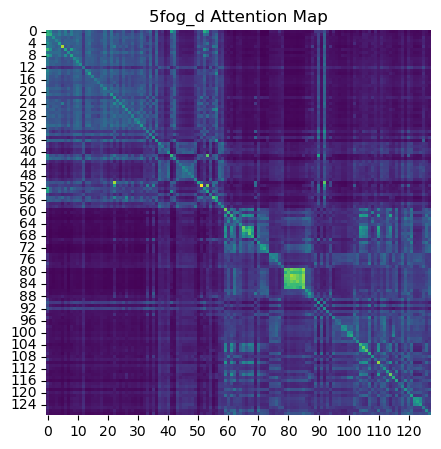

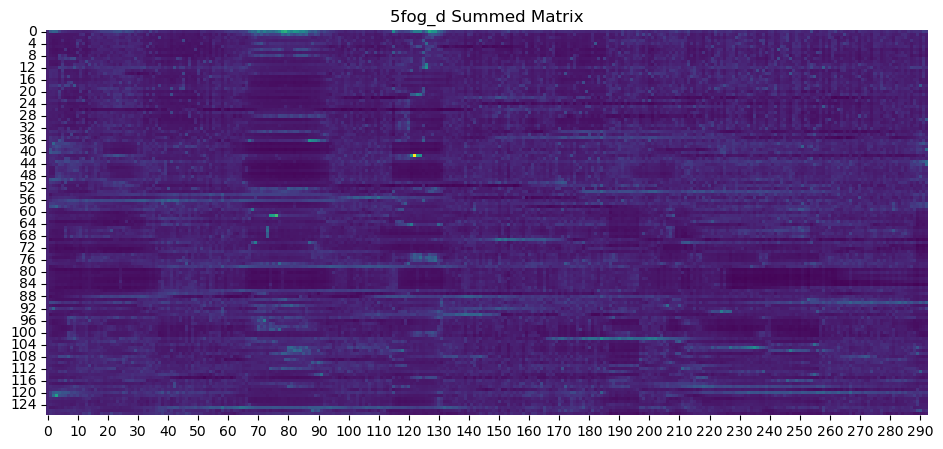

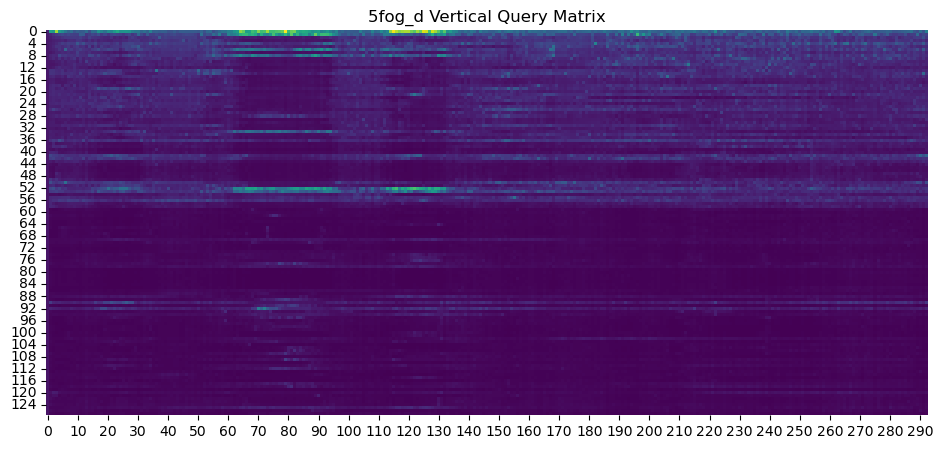

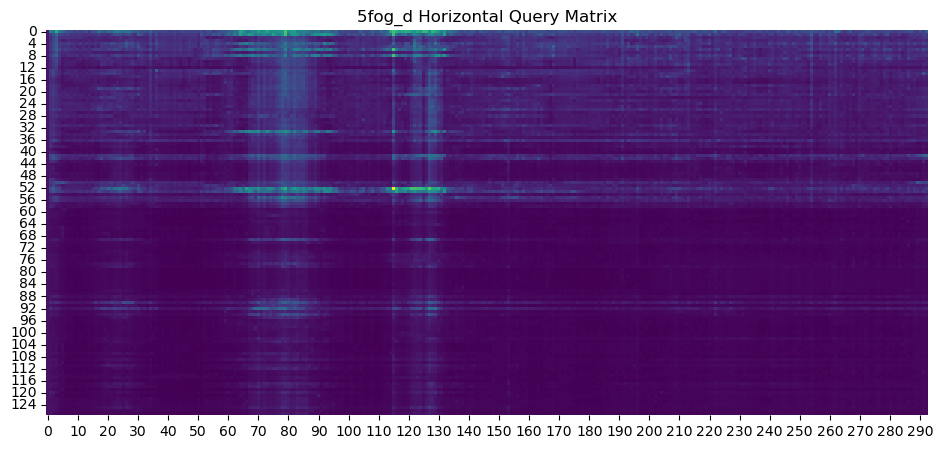

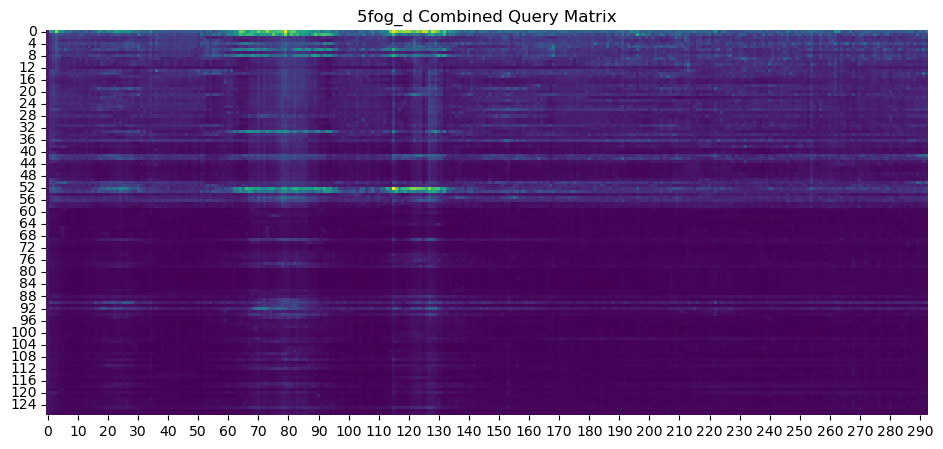

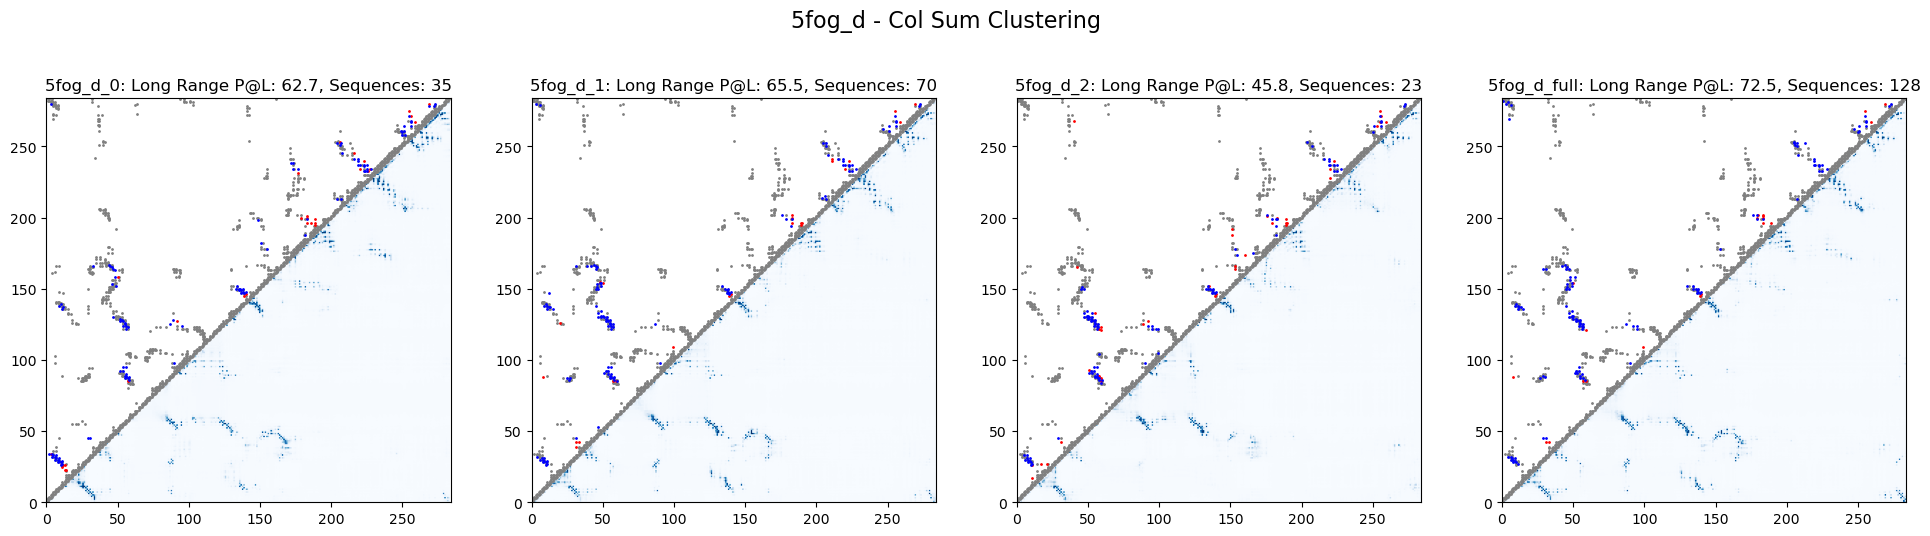

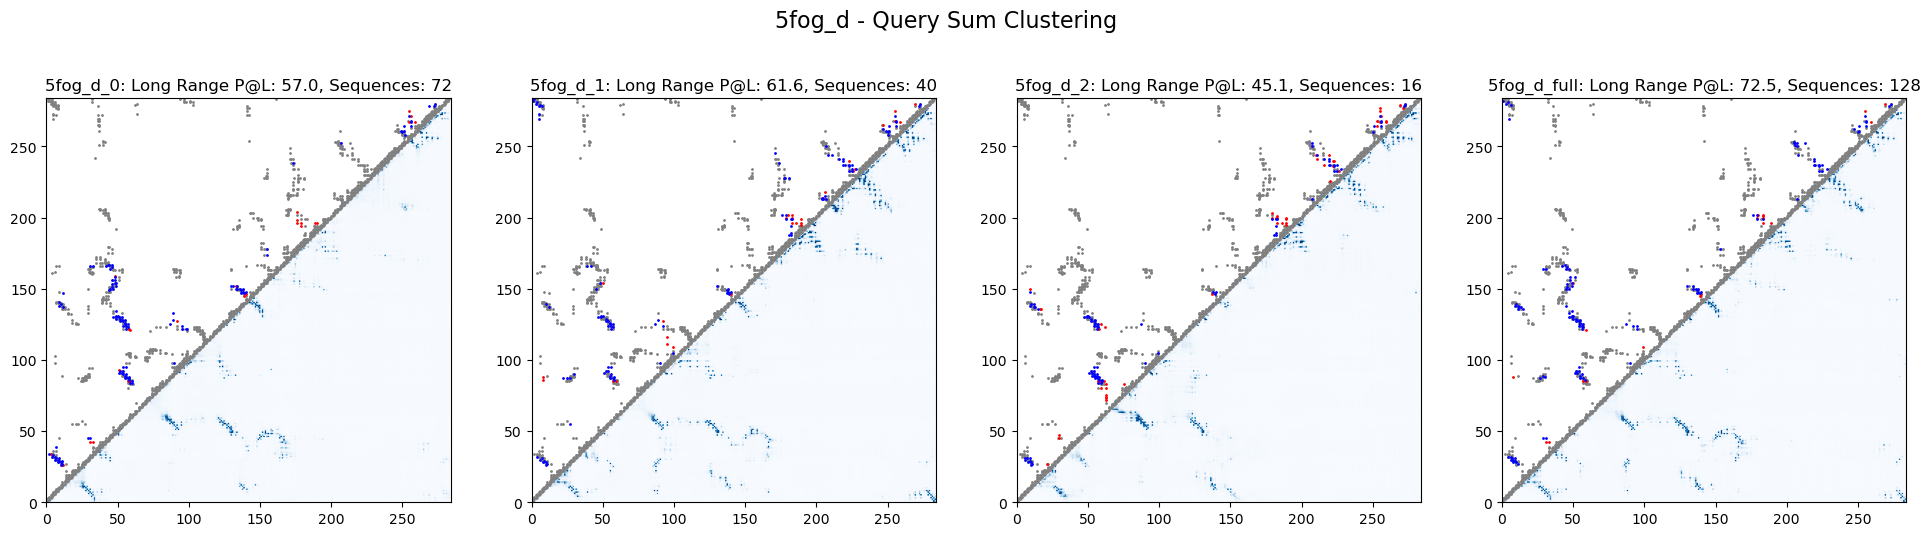

In [36]:
NUM_CLUSTERS = 3
#PDB_ID = "6gqo_a"
PDB_ID = '5fog_d'
#PDB_ID = '1c3h_a'
PDB_IDS = [PDB_ID]


def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()


inputs = read_msa(f"../data/alignments/aligned_{PDB_ID.lower()}.a3m")
cluster_inputs = greedy_select(inputs, num_seqs=128)
print(len(cluster_inputs))
msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([cluster_inputs])
msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)

with torch.no_grad():
    result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
column_attentions = result['col_attentions']
attention_maps = column_attentions[0, 0:12, 0:12, :, :, :].cpu().numpy()
print(attention_maps.shape)
summed_maps = np.sum(attention_maps, axis=(0, 1))
display_output_heatmap(np.sum(attention_maps[11,10], axis=(0)), f'{PDB_ID} Attention Map')

col_sums = np.sum(summed_maps, axis=1)
col_sum_list = [col_sums[:, i] for i in range(col_sums.shape[1])]

query_col = summed_maps[:, 0, :]
query_row = summed_maps[:, :, 0]
query_col = np.reshape(query_col, (query_col.shape[0], query_col.shape[1]))
query_row = np.reshape(query_row, (query_row.shape[0], query_row.shape[1]))
query_sum = query_col + query_row
query_list = [query_sum[:, i] for i in range(query_sum.shape[1])]
query_col_list = [query_col[:, i] for i in range(query_col.shape[1])]
query_row_list = [query_row[:, i] for i in range(query_row.shape[1])]

cluster_dict = {"Col Sum": col_sum_list, "Query Sum": query_list}
display_output_heatmap(np.transpose(col_sums), f'{PDB_ID} Summed Matrix')
display_output_heatmap(np.transpose(query_col), f'{PDB_ID} Vertical Query Matrix')
display_output_heatmap(np.transpose(query_row), f'{PDB_ID} Horizontal Query Matrix')
display_output_heatmap(np.transpose(query_sum), f'{PDB_ID} Combined Query Matrix')



single_structure = get_structure(PDBxFile.read(rcsb.fetch(PDB_ID[:4], "cif")))[0]
structures = {
    name.lower(): single_structure
    for name in PDB_IDS
}

single_contacts = contacts_from_pdb(single_structure, chain=PDB_ID.upper()[-1])
contacts = {
    name: single_contacts
    for name, structure in structures.items()
}

pdb_indices = get_pdb_residues(PDB_ID[:6])

for key in cluster_dict:

    kmeans = KMeansConstrained(
        n_clusters=NUM_CLUSTERS,
        size_min=16,
        size_max=72,
        random_state=0
    )
    kmeans.fit(cluster_dict[key])

    # Create a list of clusters that each contain a list of the indices of the sequences belonging to that cluster
    clusters = [[] for i in range(NUM_CLUSTERS)]
    for i, seq in enumerate(kmeans.labels_):
        clusters[seq].append(i)

    PDB_IDS = [PDB_ID + "_" + str(i) for i in range(NUM_CLUSTERS)]
    PDB_IDS.append(PDB_ID + '_full')

    msas = {
        name: [cluster_inputs[i] for i in clusters[num]]
        for num, name in enumerate(PDB_IDS[:-1])
    }
    msas[PDB_ID + '_full'] = cluster_inputs

    sequences = {
        name: msa[0] for name, msa in msas.items()
    }

    msa_transformer_predictions = {}
    msa_transformer_results = []

    for name, inputs in msas.items():
        msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
        msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
        msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
        if len(pdb_indices) > 0:
            msa_transformer_predictions[name] = msa_transformer_predictions[name][pdb_indices][:,pdb_indices]
        metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[PDB_ID]))
        msa_transformer_results.append(metrics)
    msa_transformer_results = pd.DataFrame(msa_transformer_results)
    #display(msa_transformer_results)


    fig, axes = plt.subplots(figsize=((NUM_CLUSTERS+1)*6, 6), ncols=(NUM_CLUSTERS+1))
    for ax, name in zip(axes, PDB_IDS):
        prediction = msa_transformer_predictions[name]
        target = contacts[PDB_ID]
        plot_contacts_and_predictions(
            prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}, Sequences: {len(msas[name])}"
        )
    # Set the title for the entire plot to be the name of the protein and the clustering method
    fig.suptitle(f"{PDB_ID} - {key} Clustering", fontsize=16)
    plt.show()

In [14]:
PDB_IDS = [PDB_ID + "_" + str(i) for i in range(NUM_CLUSTERS)]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-3]) 
    for name, structure in structures.items()
}

msas = {
    name: [cluster_inputs[i] for i in clusters[num]]
    for num, name in enumerate(PDB_IDS)
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

In [15]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    #inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    print(len(inputs))
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    pdb_indices = get_pdb_residues(name[:-2])
    if len(pdb_indices) > 0:
        msa_transformer_predictions[name] = msa_transformer_predictions[name][pdb_indices][:,pdb_indices]
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

44
72
12


,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,6gqo_a_0,MSA Transformer (Unsupervised),0.785656,0.652597,0.805195,0.885246,0.391975,0.224026,0.383117,0.57377,0.492147,0.288961,0.467532,0.721311,0.736703,0.574675,0.779221,0.852459
1,6gqo_a_1,MSA Transformer (Unsupervised),0.777404,0.662338,0.818182,0.868852,0.392849,0.217532,0.383117,0.57377,0.495591,0.285714,0.467532,0.721311,0.733236,0.577922,0.766234,0.852459
2,6gqo_a_2,MSA Transformer (Unsupervised),0.778610,0.626623,0.792208,0.885246,0.408396,0.233766,0.396104,0.57377,0.486664,0.298701,0.480519,0.704918,0.743827,0.584416,0.772727,0.868852


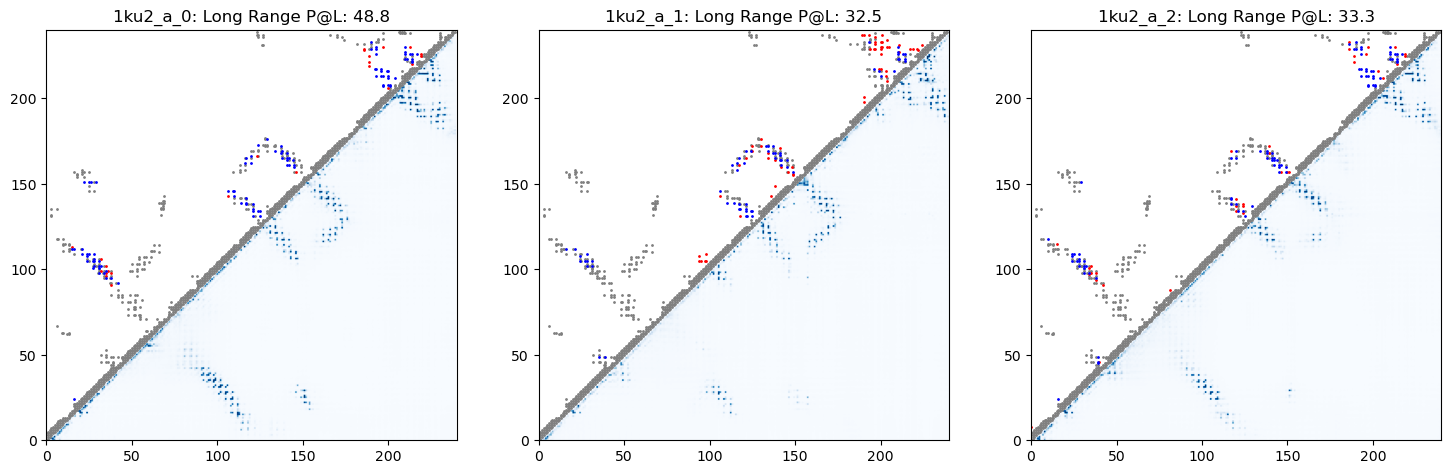

In [20]:
fig, axes = plt.subplots(figsize=(NUM_CLUSTERS*6, NUM_CLUSTERS*3), ncols=NUM_CLUSTERS)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

# Testing

In [71]:
# This is where the data is actually read in
PDB_IDS = ["1gvm_f", "5b0o_g", "1afs_a"]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

## Get indices for the residues found in the pdb structure
#pdb_residues = {
#    name: get_pdb_residues(name)
#    for name in PDB_IDS
#}

In [72]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    pdb_indices = get_pdb_residues(name)
    if len(pdb_indices) > 0:
        msa_transformer_predictions[name] = msa_transformer_predictions[name][pdb_indices][:,pdb_indices]
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1gvm_f,MSA Transformer (Unsupervised),0.734012,0.485075,0.791045,0.923077,0.806593,0.589552,0.850746,1.000000,0.624796,0.455224,0.641791,0.769231,0.431823,0.268657,0.417910,0.576923
1,5b0o_g,MSA Transformer (Unsupervised),0.864408,0.823529,0.838235,0.925926,0.234963,0.147059,0.235294,0.333333,0.324245,0.191176,0.250000,0.555556,0.678549,0.492647,0.661765,0.888889
2,1afs_a,MSA Transformer (Unsupervised),0.817094,0.686520,0.842767,0.904762,0.466012,0.266458,0.452830,0.666667,0.437005,0.231975,0.383648,0.682540,0.767191,0.664577,0.786164,0.825397


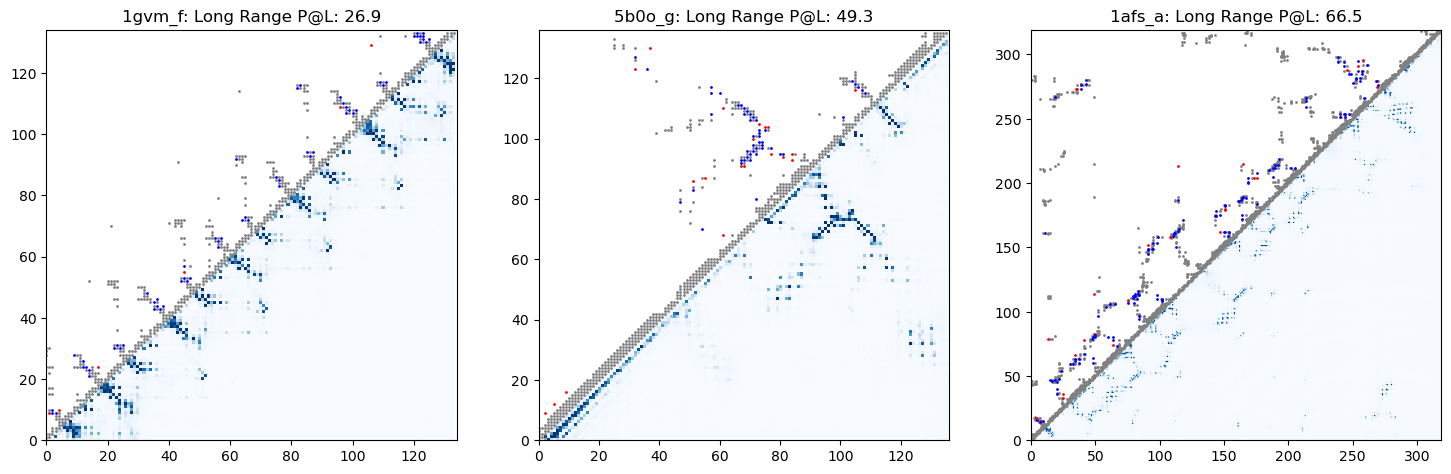

In [73]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()